# 1. - Load the CIFAR-10 dataset
- Load it as we did with the Fashion MNIST and MNIST datasets in the lesson notebooks. Create visualizations of some sample images and their corresponding labels.

| Label	| Description |
| ------|-------------|
| 0 |	airplane |
| 1 |	automobile |
| 2 |	bird |
| 3 |	cat |
| 4 |	deer |
| 5 |	dog |
| 6 |	frog |
| 7 |	horse |
| 8 |	ship |
| 9 |	truck |


In [97]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, InputLayer, Resizing, Rescaling, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.efficientnet import preprocess_input

import matplotlib.pyplot as plt

import numpy as np


In [91]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

/tmp/ipython-input-103215067.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


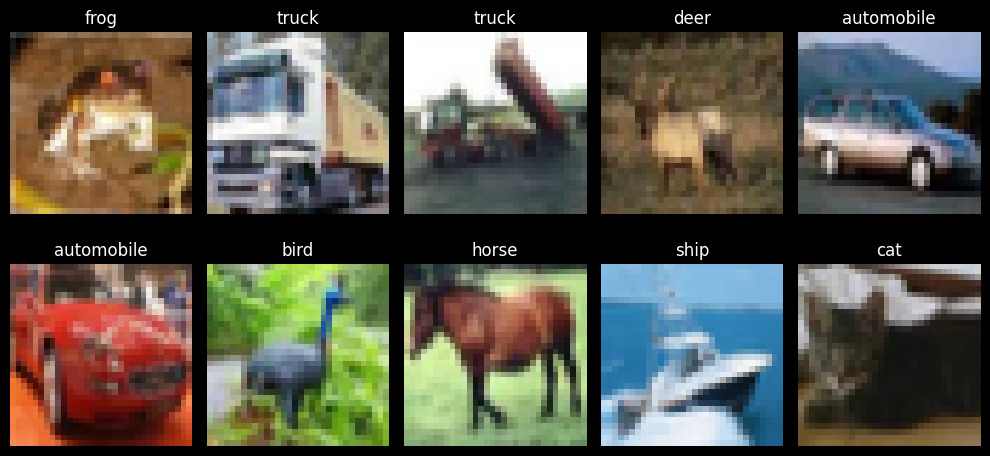

In [92]:
# Visualize some examples
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

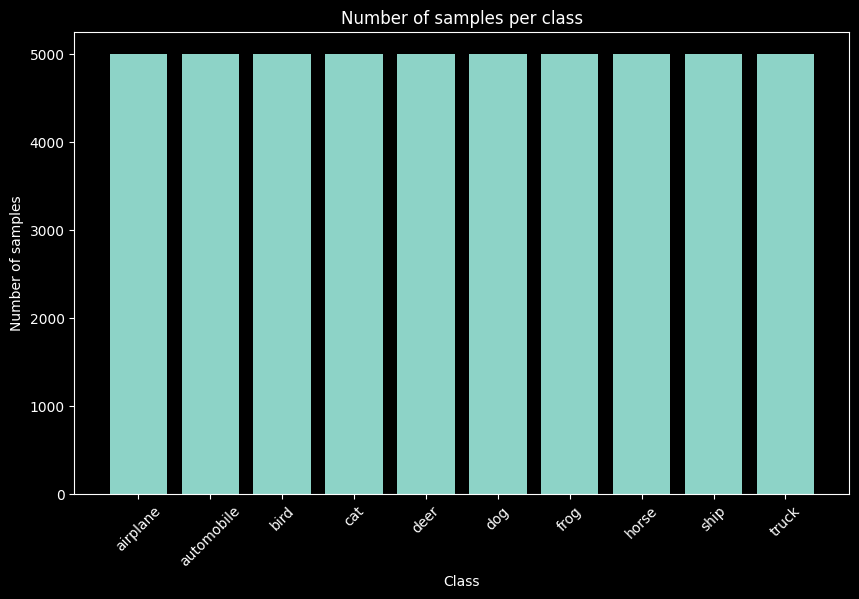

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [93]:
from collections import Counter


labels = y_train.squeeze()

# Count the number of samples per class
class_counts = Counter(labels)

# Sort by class index
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]


# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(rotation=45)
plt.show()

# Optional: print counts for reference
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")

# 2. - Preprocess your data
- Apply normalization, reshaping, label encoding, and resizing as needed.

In [143]:
# normalization -> will be done inside the model

# reshaping -> we don't need to reshape the data

# label encoding
# Convert labels to one-hot vectors
y_train_cat = to_categorical(y_train.ravel(), num_classes=10)   # y_train.ravel() -> flatten the y_train because it is 2 dimensional and we need only 1 dimension
y_test_cat = to_categorical(y_test.ravel(), num_classes=10)     # y_test.ravel() -> flatten the y_test because it is 2 dimensional and we need only 1 dimension

# resizing -> will be done inside the model

# 3. - Load your pretrained model

## 3.1 - base model

In [142]:
inputs = Input((32,32,3))                                       # the input of the model expects 32x32 px images
x = Resizing(240,240)(inputs)                                   # resize the input image to the size of imagenet
x = Lambda(preprocess_input)(x)                                 # normalize the values of the colors 0 -> -1.0 up to 255 -> +1.0
x = EfficientNetB0(include_top=False, weights="imagenet")(x)    # load pretrained model
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)                    # output layer with 10 classes to predict

model_base = Model(inputs, outputs)                               # create the model with the predefined input/output parameters

# show all layers with the index
for i, layer in enumerate(model_base.layers):
    print(i, layer.__class__.__name__)

model_base.summary()

0 InputLayer
1 Resizing
2 Lambda
3 Functional
4 GlobalAveragePooling2D
5 Dense
6 Dense


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_31 (Resizing)          │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_30 (Lambda)              │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_34     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 4,172,806 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

## 3.2 - improved model

In [141]:
inputs = Input((32,32,3))                                       # the input of the model expects 32x32 px images
x = Resizing(240,240)(inputs)                                   # resize the input image to the size of imagenet
x = Lambda(preprocess_input)(x)                                 # normalize the values of the colors 0 -> -1.0 up to 255 -> +1.0
x = EfficientNetB0(include_top=False, weights="imagenet")(x)    # load pretrained model
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)                    # output layer with 10 classes to predict

model_20 = Model(inputs, outputs)                               # create the model with the predefined input/output parameters

# show all layers with the index
for i, layer in enumerate(model_20.layers):
    print(i, layer.__class__.__name__)

backbone = model_20.layers[3]                 # extract the layer with index [3] -> EfficientNetB0
num_layers = len(backbone.layers)
fine_tune_percent = 20                        # choose which layers of EfficientNetB0 to retrain -> 20 = retrain the last 20%
fine_tune_at = int(num_layers * (1 - fine_tune_percent / 100))
for layer in backbone.layers:                 # setting all layers of EfficientNetB0 to trainable=False
    layer.trainable = False

for layer in backbone.layers[fine_tune_at:]:  # setting the choosen layers (last 20%) of EfficientNetB0 to trainable=True
    layer.trainable = True

model_20.summary()

0 InputLayer
1 Resizing
2 Lambda
3 Functional
4 GlobalAveragePooling2D
5 Dense
6 Dense


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_30 (Resizing)          │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_29 (Lambda)              │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_33     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 2,470,554 (9.42 MB)

 Non-trainable params: 1,744,275 (6.65 MB)

# 4. - Train your models
- Train at least two different CNN architectures. You can fine-tune hyperparameters such as the number of epochs (consider using early stopping), batch size, and learning rate.

## 4.1 - base model

In [99]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',       # pay attention to
    patience=10,               # how many epochs without improving before stopping the calculation
    restore_best_weights=True # keep best result, not the last one
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # pay attention to
    factor=0.5,               # LR divided by 2
    patience=5,               # how many epochs without improving before reducing the learning rate
    min_lr=1e-6,              # lowest learning rate
    verbose=1                 # show learning rate reduction in log
)

optimizer = Adam(0.001)

model_base.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 50

history_base = model_base.fit(X_train, y_train_cat,
                    batch_size= batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 235s 118ms/step - accuracy: 0.8054 - loss: 0.5852 - val_accuracy: 0.8704 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step - accuracy: 0.9093 - loss: 0.2699 - val_accuracy: 0.8906 - val_loss: 0.3278 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 116s 83ms/step - accuracy: 0.9316 - loss: 0.2025 - val_accuracy: 0.9166 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 116s 83ms/step - accuracy: 0.9456 - loss: 0.1601 - val_accuracy: 0.9118 - val_loss: 0.2838 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 116s 83ms/step - accuracy: 0.9558 - loss: 0.1336 - val_accuracy: 0.9168 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step - accuracy: 0.9601 - loss: 0.1208 - val_accuracy: 0.9212 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step 

In [100]:
model_base.save('EfficientNetB0_0_model.keras')

## 4.2 - improved model

In [128]:
early_stop = EarlyStopping(
    monitor='val_loss',       # pay attention to
    patience=10,               # how many epochs without improving before stopping the calculation
    restore_best_weights=True # keep best result, not the last one
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # pay attention to
    factor=0.5,               # LR divided by 2
    patience=5,               # how many epochs without improving before reducing the learning rate
    min_lr=1e-6,              # lowest learning rate
    verbose=1                 # show learning rate reduction in log
)

optimizer = Adam(0.001)

model_20.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 50

history = model_20.fit(X_train, y_train_cat,
                    batch_size= batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 95s 47ms/step - accuracy: 0.8368 - loss: 0.4948 - val_accuracy: 0.9236 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9277 - loss: 0.2098 - val_accuracy: 0.9392 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9470 - loss: 0.1522 - val_accuracy: 0.9332 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9593 - loss: 0.1197 - val_accuracy: 0.9416 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9651 - loss: 0.1072 - val_accuracy: 0.9432 - val_loss: 0.1972 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9715 - loss: 0.0843 - val_accuracy: 0.9356 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accura

In [129]:
model_20.save('EfficientNetB0_20_model.keras')

# 5. - Evaluate your models
- Report metrics such as accuracy, precision, recall, and F1-score, and visualize the confusion matrix to analyze class-wise performance.

## 5.1 - base model

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

model_base = load_model(
    "EfficientNetB0_0_model.keras",
    custom_objects={"preprocess_input": preprocess_input},
    compile=False
    )

# Predict class probabilities
y_pred_probs = model_base.predict(X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test  # original integer labels

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step
Accuracy: 0.9483
Precision: 0.9484
Recall: 0.9483
F1 Score: 0.9483


In [103]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.96      0.94      0.95      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.94      0.94      0.94      1000
         cat       0.90      0.88      0.89      1000
        deer       0.94      0.97      0.95      1000
         dog       0.91      0.92      0.91      1000
        frog       0.97      0.97      0.97      1000
       horse       0.98      0.96      0.97      1000
        ship       0.95      0.97      0.96      1000
       truck       0.98      0.95      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


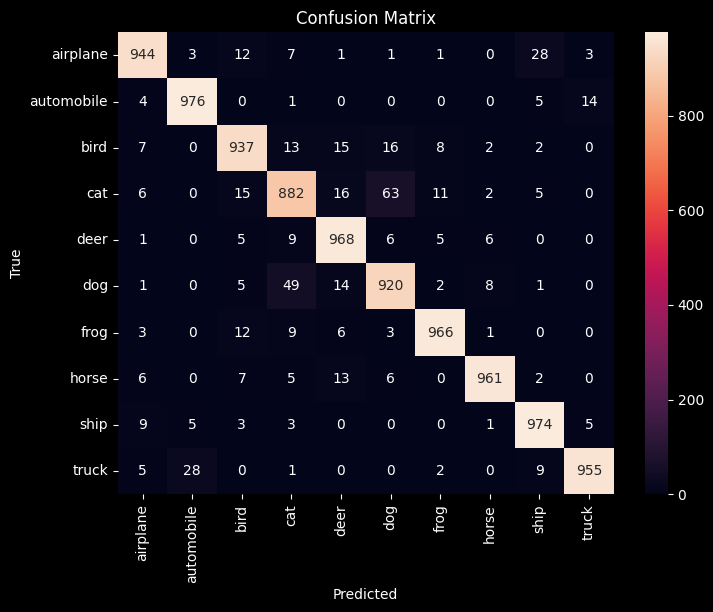

In [104]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict & confusion matrix
y_pred = model_base.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

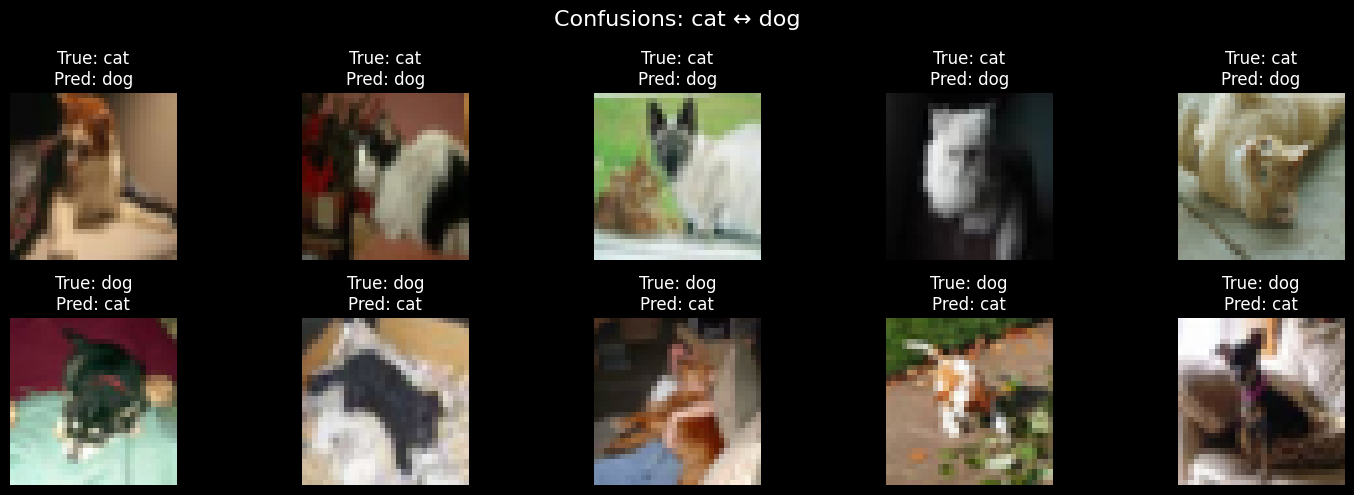

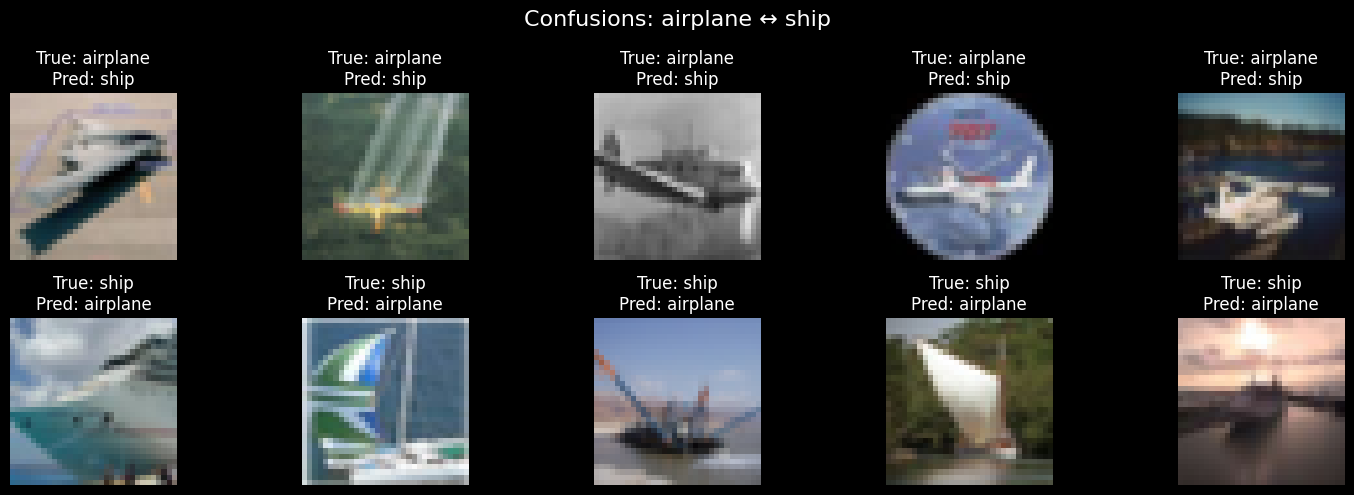

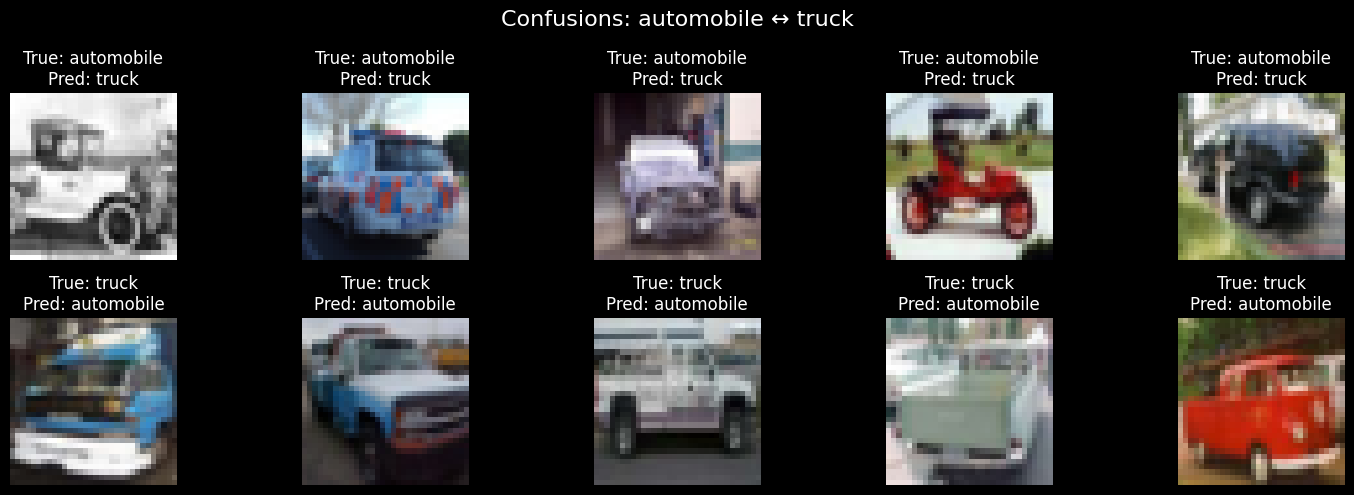

In [105]:
# Make sure y_pred and y_true are numpy arrays
y_pred = np.array(y_pred).reshape(-1)
y_true = np.array(y_true).reshape(-1)

# Convert X_test to numpy if it's a TensorFlow tensor
X_test_np = X_test.numpy() if hasattr(X_test, 'numpy') else X_test

# Confusing class pairs to inspect
confusing_pairs = [
    (3, 5),  # cat vs dog
    (0, 8),  # airplane vs ship
    (1, 9)   # automobile vs truck
]

# Function to plot misclassified images between two specific classes
def show_confusion_examples(y_true, y_pred, X, class1, class2, n=5):
    # Find indices of images where class1 was confused with class2 and vice versa
    idx_confused_1 = np.where((y_true == class1) & (y_pred == class2))[0]
    idx_confused_2 = np.where((y_true == class2) & (y_pred == class1))[0]

    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    fig.suptitle(f"Confusions: {class_names[class1]} ↔ {class_names[class2]}", fontsize=16)

    idx1 = idx_confused_1[:n]
    idx2 = idx_confused_2[:n]

    for i in range(n):
        if i < len(idx1):
            ax = axes[0, i]
            ax.imshow(X[idx1[i]])
            ax.set_title(f"True: {class_names[class1]}\nPred: {class_names[class2]}")
            ax.axis('off')
        else:
            axes[0, i].axis('off')

        if i < len(idx2):
            ax = axes[1, i]
            ax.imshow(X[idx2[i]])
            ax.set_title(f"True: {class_names[class2]}\nPred: {class_names[class1]}")
            ax.axis('off')
        else:
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.style.use('dark_background')
    plt.show()

# Show misclassifications for each confusing pair
for class1, class2 in confusing_pairs:
    show_confusion_examples(y_true, y_pred, X_test_np, class1, class2)


## 5.2 - improved model

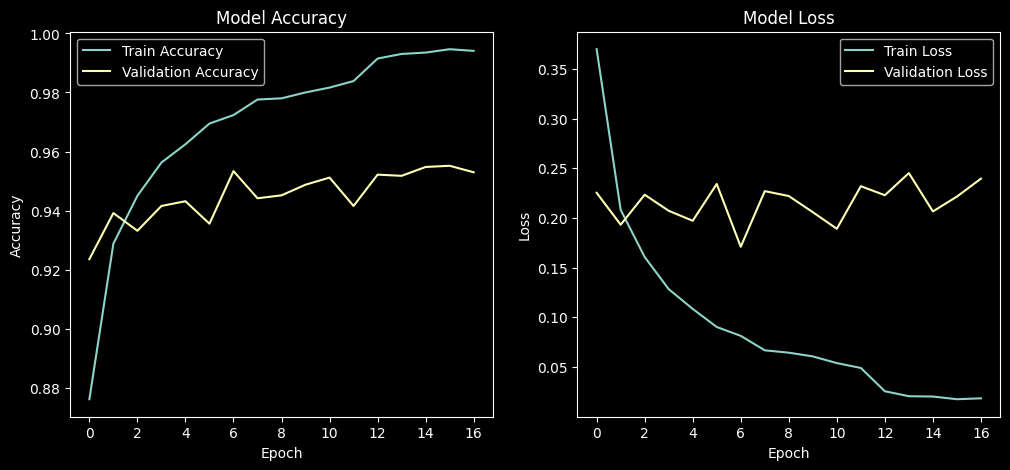

In [132]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = load_model(
    "EfficientNetB0_20_model.keras",
    custom_objects={"preprocess_input": preprocess_input},
    compile=False
    )

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test  # original integer labels

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step
Accuracy: 0.9466
Precision: 0.9468
Recall: 0.9466
F1 Score: 0.9466


In [134]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.96      0.95      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.93      0.94      0.94      1000
         cat       0.88      0.91      0.89      1000
        deer       0.95      0.94      0.95      1000
         dog       0.92      0.89      0.91      1000
        frog       0.96      0.98      0.97      1000
       horse       0.96      0.96      0.96      1000
        ship       0.97      0.97      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


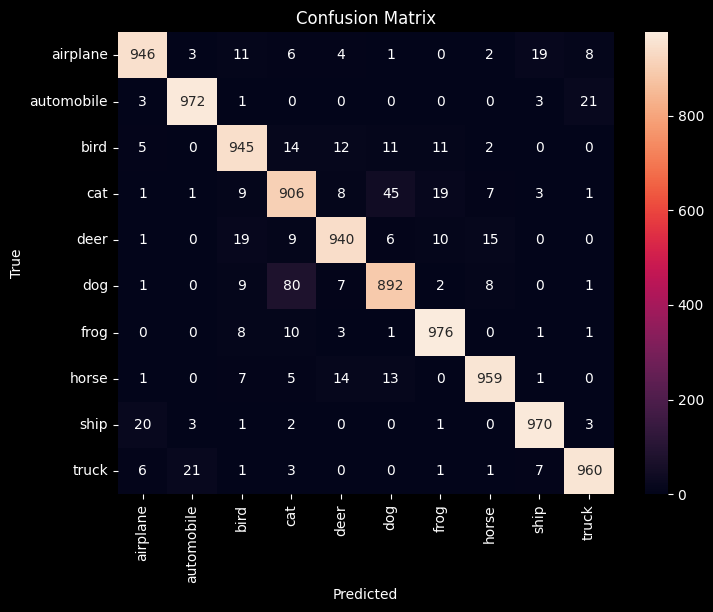

In [135]:
# Predict & confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

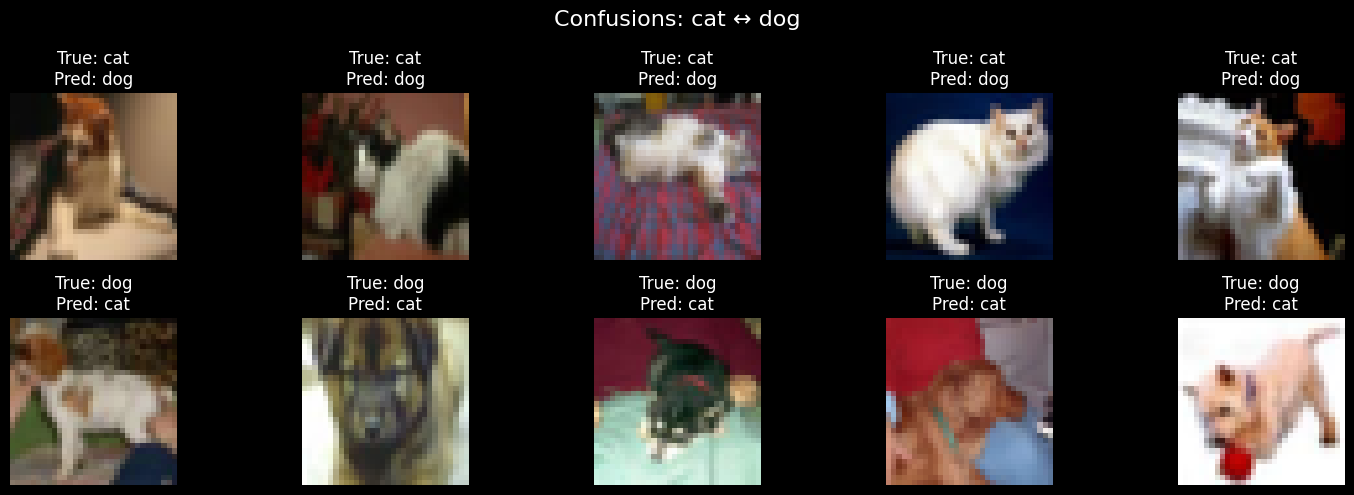

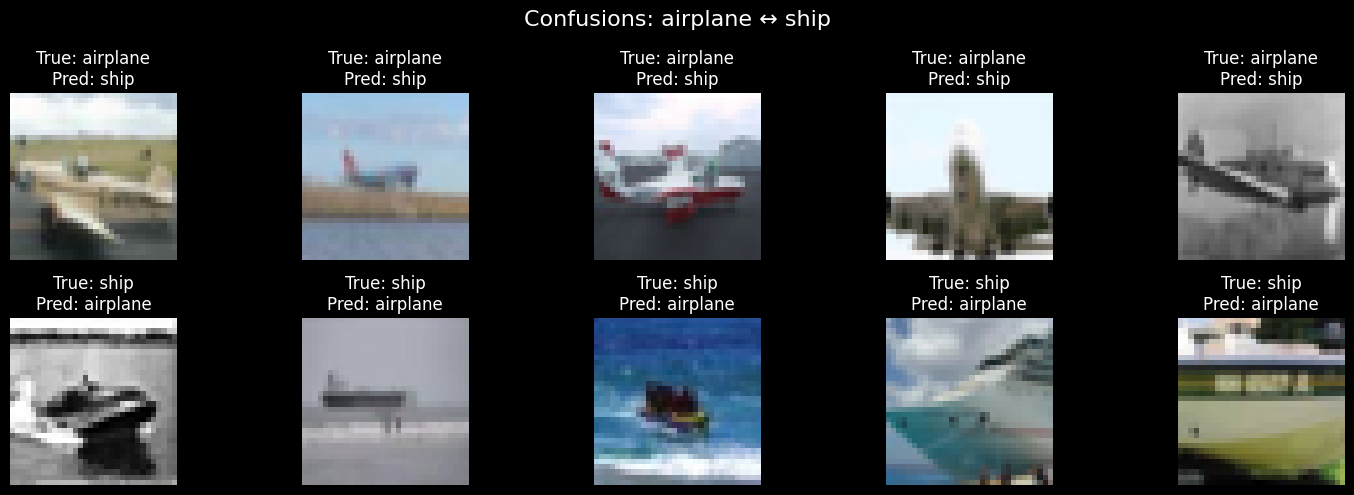

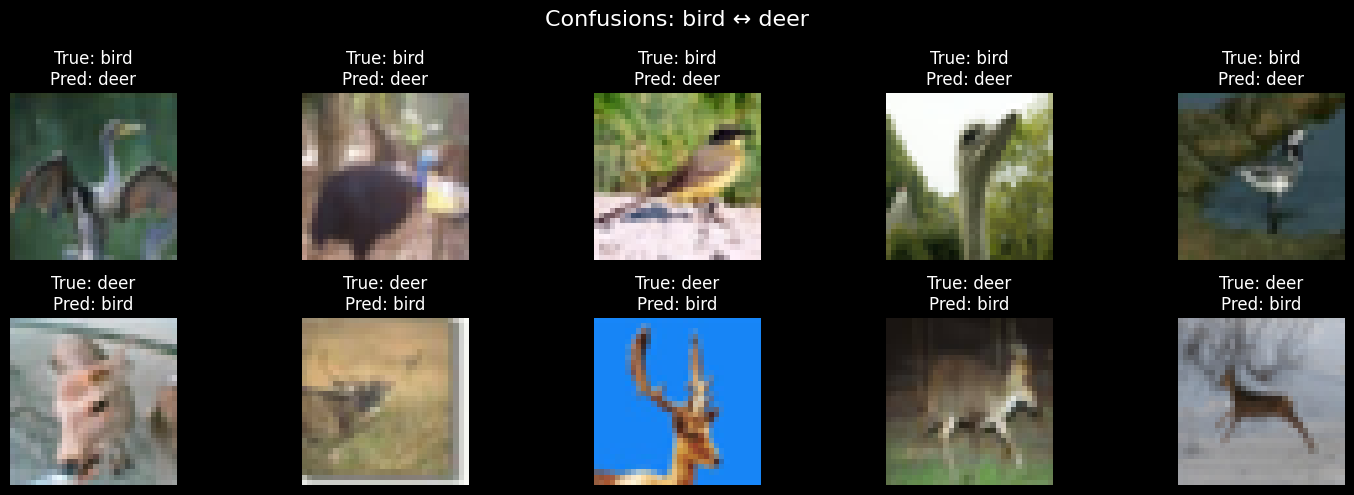

In [ ]:
# Make sure y_pred and y_true are numpy arrays
y_pred = np.array(y_pred).reshape(-1)
y_true = np.array(y_true).reshape(-1)

# Convert X_test to numpy if it's a TensorFlow tensor
X_test_np = X_test.numpy() if hasattr(X_test, 'numpy') else X_test

# Confusing class pairs to inspect
confusing_pairs = [
    (3, 5),  # cat vs dog
    (0, 8),  # airplane vs ship
    (2, 4),  # bird vs deer
]

# Function to plot misclassified images between two specific classes
def show_confusion_examples(y_true, y_pred, X, class1, class2, n=5):
    # Find indices of images where class1 was confused with class2 and vice versa
    idx_confused_1 = np.where((y_true == class1) & (y_pred == class2))[0]
    idx_confused_2 = np.where((y_true == class2) & (y_pred == class1))[0]

    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    fig.suptitle(f"Confusions: {class_names[class1]} ↔ {class_names[class2]}", fontsize=16)

    idx1 = idx_confused_1[:n]
    idx2 = idx_confused_2[:n]

    for i in range(n):
        if i < len(idx1):
            ax = axes[0, i]
            ax.imshow(X[idx1[i]])
            ax.set_title(f"True: {class_names[class1]}\nPred: {class_names[class2]}")
            ax.axis('off')
        else:
            axes[0, i].axis('off')

        if i < len(idx2):
            ax = axes[1, i]
            ax.imshow(X[idx2[i]])
            ax.set_title(f"True: {class_names[class2]}\nPred: {class_names[class1]}")
            ax.axis('off')
        else:
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.style.use('dark_background')
    plt.show()

# Show misclassifications for each confusing pair
for class1, class2 in confusing_pairs:
    show_confusion_examples(y_true, y_pred, X_test_np, class1, class2)


# 6. - predict category of own picture


## 6.1 - load own picture and convert

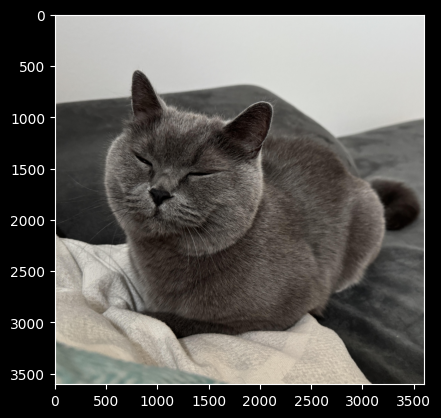

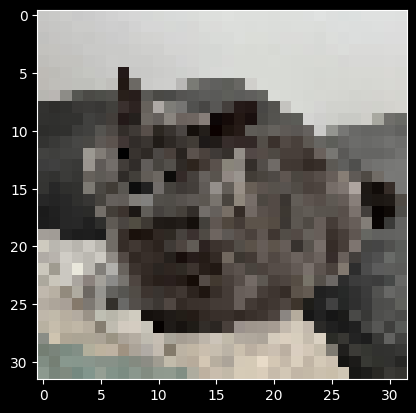

In [124]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# load picture
img_orig = load_img("cat_1.jpg")
img = load_img("cat_1.jpg", target_size=(32, 32))
plt.imshow(img_orig)
plt.show()
plt.imshow(img)
plt.show()

# convert to numpy array
img = img_to_array(img)

# add batch dimension
img = np.expand_dims(img, axis=0)   # → (1, 32, 32, 3)

## 6.2 - predict the category of own picture

In [136]:
y_pred = model_base.predict(img)

predicted_class = class_names[np.argmax(y_pred)]
print("predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predicted class: cat
